In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable
from matplotlib.patches import Patch  # Per creare elementi di legenda personalizzati

In [2]:
#confronto for-single thread con par_for_sure_n con n_blocchi variabile
def plot_boxplot(data_for, data_par_for_n,title):
    fig, ax = plt.subplots(figsize=[10, 8])
    
    boxs = []
    ticks = []
    boxs.append(data_for)
    ticks.append("sequential")
    for i in range(len(data_par_for_n)):
        boxs.append(data_par_for_n[i])
        ticks.append(str(n_threads[i]))

    
    bplot = ax.boxplot(boxs, showfliers=False, patch_artist=True)

    ax.set(xlabel = 'thread (worker)',ylabel = 'Microseconds')
    ax.set_title( title, loc = 'left')
    ax.set_xticks(range(1,1+len(boxs)),ticks)
    ax.set_yscale('log')

    # Colora ogni box
    colors = ['orange'] + ['blue'] * (len(bplot['boxes']) - 1)
    for box, color in zip(bplot['boxes'], colors):
        box.set_facecolor(color)

    # Crea legenda con Patch
    legend_handles = [
        Patch(facecolor='orange', label='grid search seq'),
        Patch(facecolor='blue', label='grid search parallel')
    ]
    ax.legend(handles=legend_handles, loc='upper right')

    plt.figtext(0.63, 0.9, f"threadpool: size_queue({size_queue})\nsize_grid : {sizegrid}\nruns: {len(data_for)}\ngranularity: {granularity}", fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black'))
    # --- Print delle mediane dei boxplot ---
    medians = [np.median(d) for d in boxs]
    print("\n=== Median values (µs) ===")
    for label, median in zip(ticks, medians):
        print(f"{label}: {median:.2f}")
    print("===========================\n")

In [3]:
def plot_speedup(data_list,title,n_threads): #primo data in data_list è for normale e poi si compara con quello
    fig, ax = plt.subplots(figsize=[16, 8])

    data_median = [np.median(datum) for datum in data_list] #cambioato uso mediana non media #[np.mean(datum) for datum in data_list]
    speedup = np.zeros(len(n_threads))


    for i in range(len(n_threads)):
        speedup[i] = data_median[0]/data_median[i+1]
        

    ax.plot(n_threads,speedup,'o--')

    ax.legend(['speedup','maximum'])
    ax.set_title(title, loc= 'left')
    ax.set_xticks(n_threads)
    ax.set_xticklabels(n_threads, rotation = 45)


    ax.set(xlabel = 'workers (thread)',ylabel = 'speedup')
    plt.figtext(0.7, 0.9, f"threadpool: size_queue({size_queue})\nsize_grid: {sizegrid}\nruns: {len(data_list[0])}\ngranularity: {granularity}", fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black'))
    
    # --- Print dei valori di speedup con thread ---
    for n, s in zip(n_threads, speedup):
        print(f"{n} threads -> speedup: {s:.2f}")
    

## prestazioni ggrid search parallel

In [4]:
!rm *.txt

rm: cannot remove '*.txt': No such file or directory


fare test con sizegrid:10^6 e granularity: 10^4, sizegrid: 10^7 e granularity: 10^5

In [41]:
#a mano settali uguali a come runnato in cluster 
#set parameter
n_runs = 10
sizegrid = 10000000
n_threads = [1,2,3,4,5,6,7,8] #,10,16,32,64,128]
size_queue = 1024 #hardcome in codice ma qui non conta
granularity = 100000
funzione = "rastrigin"#"matrix_function A*B, size_matrix:50 "
size_matrix = 50 #hardcode in test_optimization*.cpp, indica quanto pesante è funzione da valiuatre su ogni elem di griglia (funzione fa prodotto tra eigen matrix di dim size_matrix)


In [6]:
#run manualmente seq,   nruns sizegrid 
!./run_optimization.sh 10 1000000

In [14]:
#run manualmente parallel cambiando n_thread,   nruns sizegrid n_thread granularity  
!./run_optimization_parallel.sh 10 1000000 8 10000 

In [47]:
# run test granularity
dati_assemble = []
dati_assemble = np.genfromtxt("test_optimization_sizegrid"+str(sizegrid)+".txt",delimiter=',',dtype=int)[:-1]
dati_assemble_parallel = []
for i,nb in enumerate(n_threads):
    dati_assemble_parallel.append(np.genfromtxt("test_optimization_sizegrid"+str(sizegrid)+"_thread"+str(nb)+".txt",delimiter=',',dtype=int)[:-1])


=== Median values (µs) ===
sequential: 433006.50
1: 436457.00
2: 230519.50
3: 171591.00
4: 135733.50
5: 123073.50
6: 115539.50
7: 109460.50
8: 103537.50



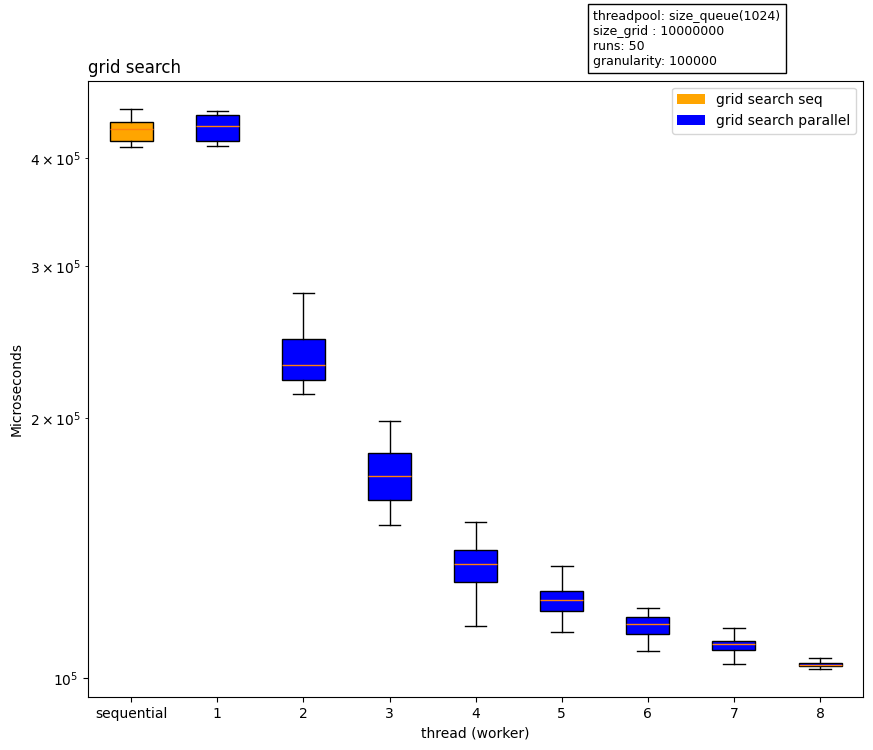

In [48]:
plot_boxplot(dati_assemble, dati_assemble_parallel,"grid search")

1 threads -> speedup: 0.99
2 threads -> speedup: 1.88
3 threads -> speedup: 2.52
4 threads -> speedup: 3.19
5 threads -> speedup: 3.52
6 threads -> speedup: 3.75
7 threads -> speedup: 3.96
8 threads -> speedup: 4.18


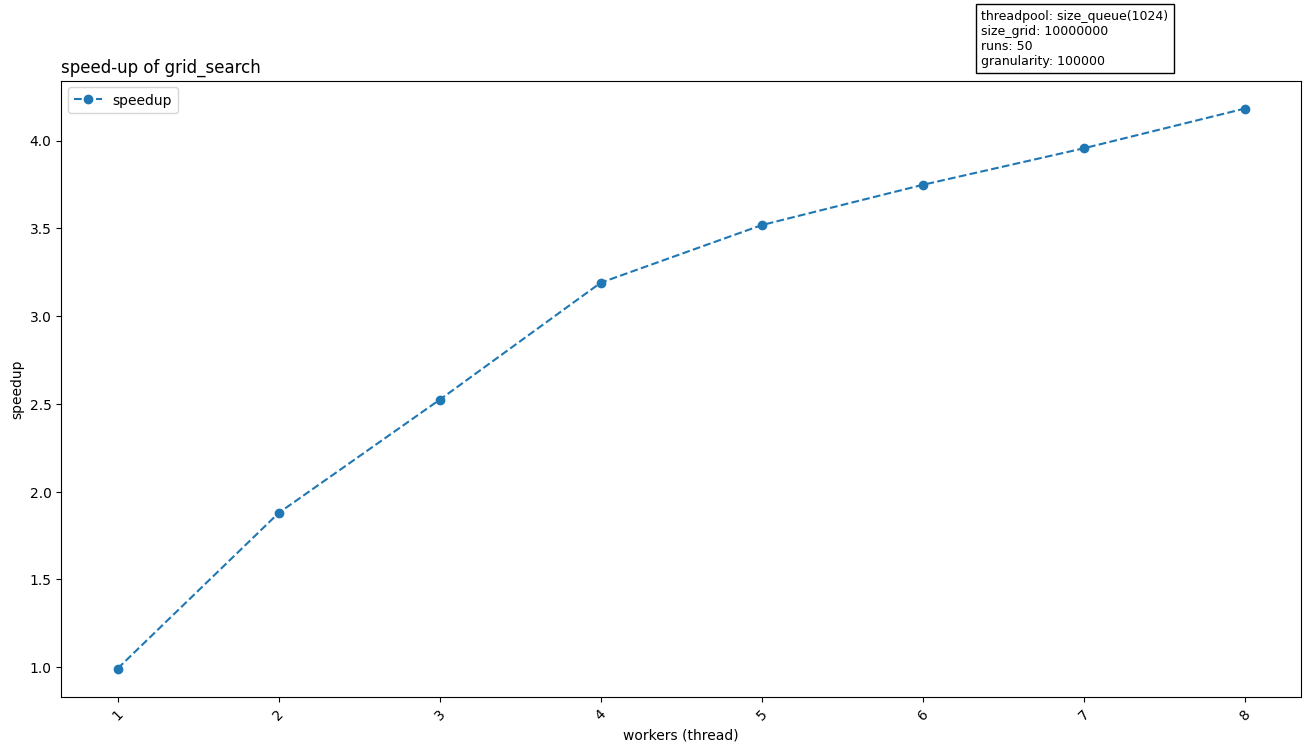

In [49]:
data_list = []
data_list.append(dati_assemble)
for i in range(len(n_threads)):
    data_list.append(dati_assemble_parallel[i])
plot_speedup(data_list,"speed-up of grid_search",n_threads)

## fix thread cambia granularity


In [57]:
def plot_granularity(data_for, data_par_for_n,title):
    fig, ax = plt.subplots(figsize=[10, 8])
    
    boxs = []
    ticks = []
    boxs.append(data_for)
    ticks.append("sequential")
    for i in range(len(data_par_for_n)):
        boxs.append(data_par_for_n[i])
        ticks.append(str(granularity[i]))

    
    bplot = ax.boxplot(boxs, showfliers=False, patch_artist=True)

    ax.set(xlabel = 'granularity',ylabel = 'Microseconds')
    ax.set_title( title, loc = 'left')
    ax.set_xticks(range(1,1+len(boxs)),ticks)
    ax.set_yscale('log')

    # Colora ogni box
    colors = ['orange'] + ['blue'] * (len(bplot['boxes']) - 1)
    for box, color in zip(bplot['boxes'], colors):
        box.set_facecolor(color)

    # Crea legenda con Patch
    legend_handles = [
        Patch(facecolor='orange', label='for'),
        Patch(facecolor='blue', label='parallel_for')
    ]
    ax.legend(handles=legend_handles, loc='upper right')

    plt.figtext(0.63, 0.9, f"threadpool: n_thread({n_thread}), size_queue({size_queue})\nsize_grid : {sizegrid}\nruns: {len(data_for)}", fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black'))
    
    # --- Print delle mediane dei boxplot ---
    medians = [np.median(d) for d in boxs]
    print("\n=== Median values (µs) ===")
    for label, median in zip(ticks, medians):
        print(f"{label}: {median:.2f}")
    print("===========================\n")

In [58]:
def plot_speedup_granularity(data_list,title,gran): #primo data in data_list è for normale e poi si compara con quello
    fig, ax = plt.subplots(figsize=[16, 8])

    data_median = [np.median(datum) for datum in data_list]
    speedup = np.zeros(len(gran))


    for i in range(len(gran)):
        speedup[i] = data_median[0]/data_median[i+1]
        

    #print(data_list)
    #print(data_mean)
    gran = gran[::-1]
    speedup = speedup[::-1]
    ax.plot(gran,speedup,'o--')

    ax.legend(['speedup'])
    ax.set_title(title, loc= 'left')
    ax.set_xticks(gran)
    ax.set_xticklabels(gran, rotation = 45)


    ax.set(xlabel = 'graularity'+str(gran),ylabel = 'speedup')
    plt.figtext(0.7, 0.9, f"threadpool: n_thread({n_thread}), size_queue({size_queue})\nsize_grid: {size_grid}\nruns:{len(data_list[0])}", fontsize=9, 
            bbox=dict(facecolor='white', edgecolor='black'))
    
    # --- Stampa degli speedup ---
    print("\n=== Speedup values ===")
    for g, s in zip(gran, speedup):
        print(f"Granularity {g}: speedup = {s:.2f}")
    print("=====================\n")

In [53]:
granularity = [1000000,100000,10000,1000] 
size_grid = 6000000
n_thread = 6
size_queue = 1024 #hardcode ma tanto qui inutile

In [21]:
#run manualmente seq,   nruns sizegrid  (for per calcolo speedup)
!./run_optimization.sh 3 6000000

In [28]:
#run manualmente parallel cambiando granularity,   nruns sizegrid n_thread granularity 
!./run_optimization_parallel_fixthread_granularity.sh 3 6000000 6 1000000 

In [65]:
dati_seq = []
dati_seq =np.genfromtxt("test_optimization_sizegrid"+str(size_grid)+".txt",delimiter=',',dtype=int)[:-1]
dati_par = []
for i,nb in enumerate(granularity):
    dati_par.append(np.genfromtxt("test_optimization_sizegrid"+str(size_grid)+"_thread"+str(n_thread)+"_granularity"+str(nb)+".txt",delimiter=',',dtype=int)[:-1])


=== Median values (µs) ===
sequential: 267298.50
1000000: 77303.00
100000: 70268.50
10000: 72489.50
1000: 80876.50



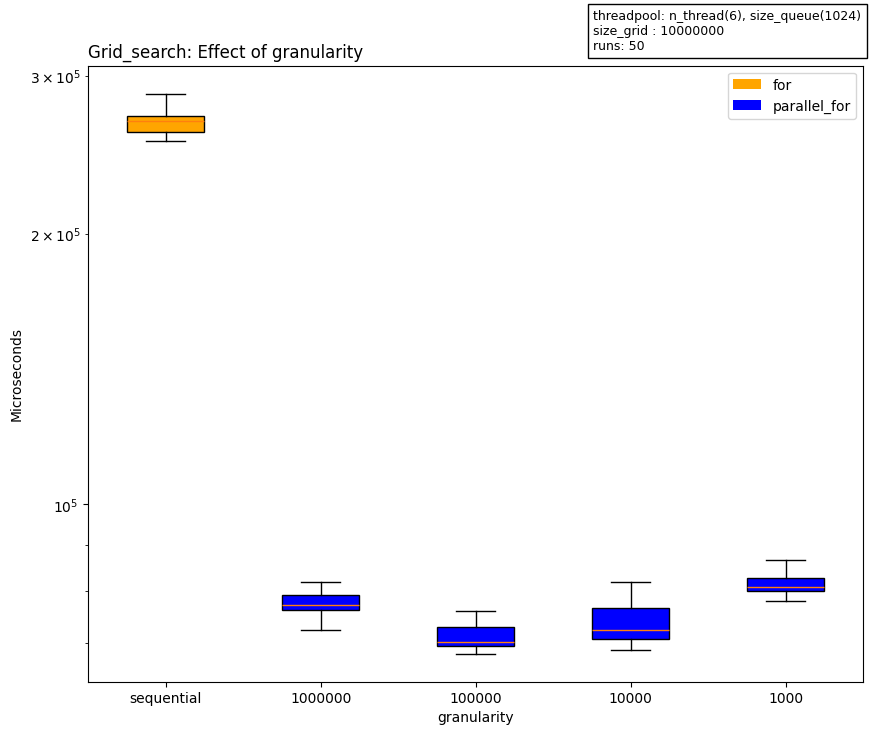

In [66]:
plot_granularity(dati_seq,dati_par,"Grid_search: Effect of granularity")


=== Speedup values ===
Granularity 1000: speedup = 3.31
Granularity 10000: speedup = 3.69
Granularity 100000: speedup = 3.80
Granularity 1000000: speedup = 3.46



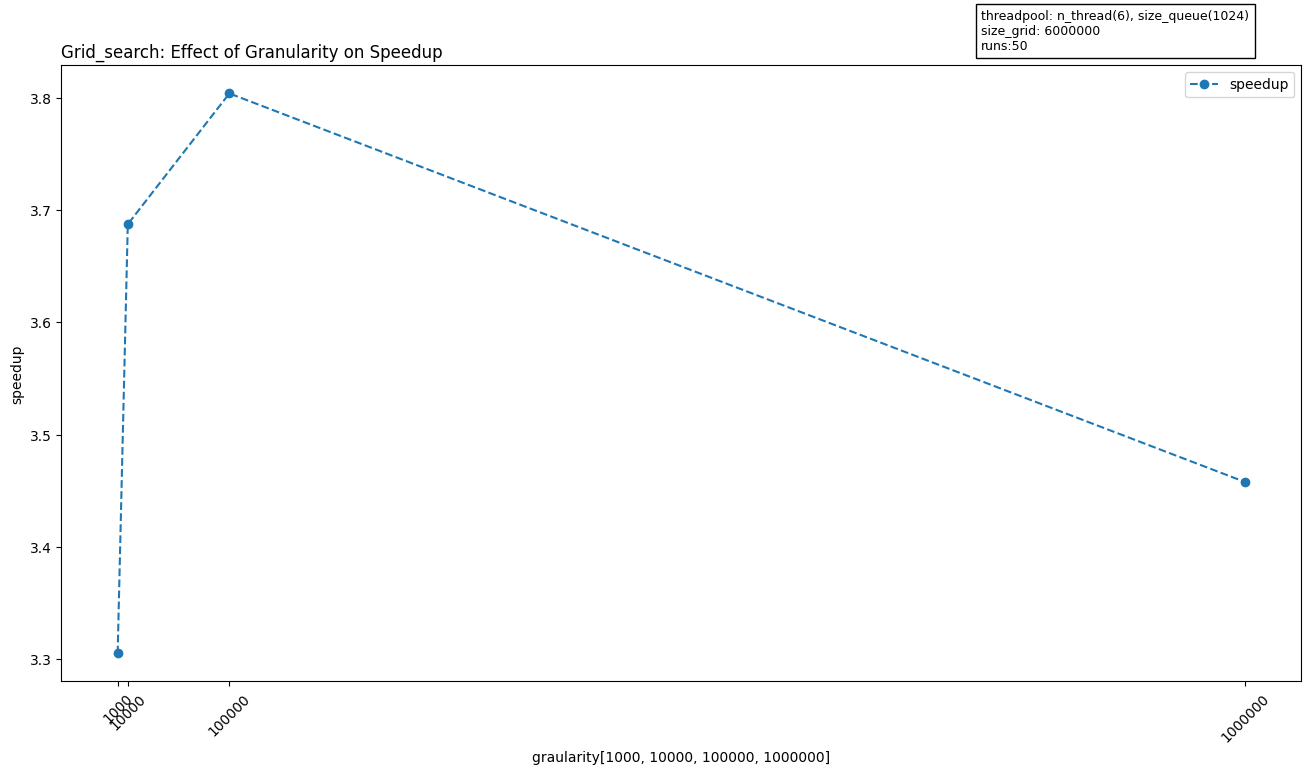

In [67]:
data_list = []
data_list.append(dati_seq)
for i,n in enumerate(granularity):
    data_list.append(dati_par[i])
plot_speedup_granularity(data_list,"Grid_search: Effect of Granularity on Speedup",granularity)